# Observed Markov Models for new pipeline

Translated from R as written here: https://github.com/prio-data/viewsforecasting/tree/main/Tools/new_markov

## 0. Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import importlib

# set path
import sys, os
sys.path.append(os.path.abspath(".."))

from src import markov_model
importlib.reload(markov_model)
from src.markov_model import MarkovModel

## 1. Import test dataset(s)

In [8]:
data = pd.read_parquet("../data/testdataset.parquet")

## 2. Initialize and fit Markov models:

Model parameters:

In [ ]:
random_seed = 42
partitioner_dict = {"train":(121,408),"test":(409,456)}

Initialize Markov model using direct method:

In [10]:
mm_direct = MarkovModel(
    partitioner_dict=partitioner_dict,
    markov_method="direct",
    random_state=random_seed
)

And using transition matrix method:

In [11]:
mm_transition = MarkovModel(
    partitioner_dict=partitioner_dict,
    markov_method="transition",
    random_state=random_seed
)

Fit for with direct method. Expected run time is around 15 minutes.

In [16]:
mm_direct.fit(
    data=data,
    steps=range(1, 37),
    target="ged_sb",
)

Fitting Random Forest Classifier for state: war and step: 36                      
Finished fitting Random Forest Classifiers for all Markov states.
Fitting Random Forest Regressor for state: war                    
Finished fitting Random Forest Regressors for all Markov states.


And fit with transition matrix method. Expected run time is around 30 seconds.

In [12]:
mm_transition.fit(
    data=data,
    steps=range(1, 37),
    target="ged_sb",
)

Fitting Random Forest Classifier for state: war and step: 1                      
Finished fitting Random Forest Classifiers for all Markov states.
Fitting Random Forest Regressor for state: war                    
Finished fitting Random Forest Regressors for all Markov states.


## 3. Make predictions

Now make predictions with both the direct method and transition matrix method models:

In [17]:
predictions_direct = mm_direct.predict(
    data=data,
    steps=range(1,37),
)

Predicting step 36 using direct method.                    
Finished predicting for all steps.


In [14]:
predictions_transition = mm_transition.predict(
    data=data,
    steps=range(1,37),
)

Predicting step 36 using transition method.                    
Finished predicting for all steps.


And now to compare with the actuals, we first merge the predictions from both method together:

In [18]:
# merge predictions direct with predictions transition on index
predictions_merged = predictions_direct.merge(
    predictions_transition,
    left_index=True,
    right_index=True,
    suffixes=('_direct', '_transition')
)

And then merge with the actuals:

In [19]:
actuals = data.rename_axis(index={"month_id": "target_month_id"})

# merge with actuals from data
predictions_merged = predictions_merged.merge(
    actuals[["ged_sb"]],
    left_index=True,
    right_index=True
)

And then we can make a basic MSE plot over steps ahead:

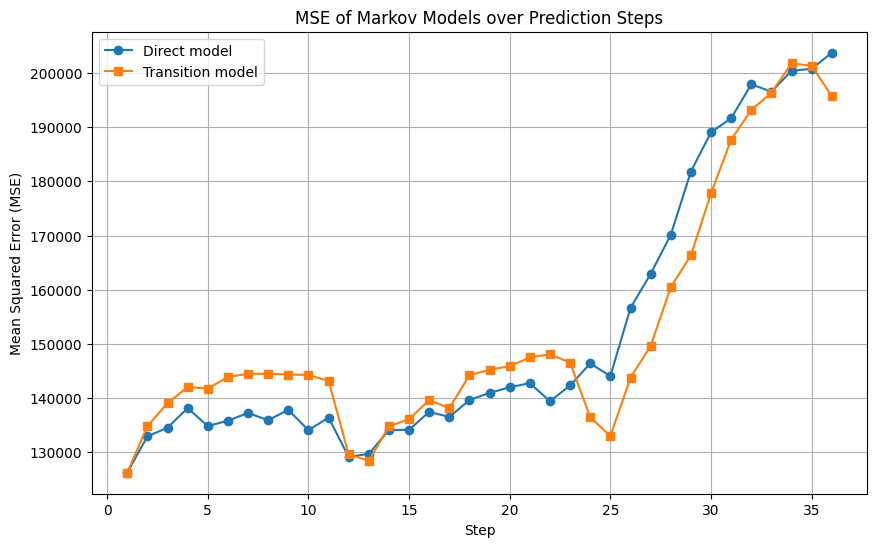

In [22]:
df = predictions_merged.copy()

# get all prediction columns
direct_cols = [c for c in df.columns if "direct" in c]
transition_cols = [c for c in df.columns if "transition" in c]

# compute square error
direct_errors = (df[direct_cols] - df["ged_sb"].values[:, None]) ** 2
transition_errors = (df[transition_cols] - df["ged_sb"].values[:, None]) ** 2

# compute mse over all rows
direct_mse = direct_errors.mean()
transition_mse = transition_errors.mean()

# get step numbers from column names
direct_steps = [int(c.split("_")[4]) for c in direct_mse.index]
transition_steps = [int(c.split("_")[4]) for c in transition_mse.index]

# combine into MSE df
mse_df = pd.DataFrame({
    "step": direct_steps,
    "direct_mse": direct_mse.values,
    "transition_mse": transition_mse.values
}).sort_values("step")

# plot
plt.figure(figsize=(10,6))
plt.plot(mse_df["step"], mse_df["direct_mse"], marker="o", label="Direct model")
plt.plot(mse_df["step"], mse_df["transition_mse"], marker="s", label="Transition model")
plt.xlabel("Step")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE of Markov Models over Prediction Steps")
plt.legend()
plt.grid(True)
plt.show()
